# Data Stream Management System: Social Network Analysis and Mining

The goal of this notebook is to retrieve, filter, store and analyze an information flow from a popular social network.

In [1]:
# Useful libraries
import re
import time
import json
import string
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener

import mysql.connector
from mysql.connector import errorcode

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer

## PART 1: Prepare Schema and connect to DB

First, let's create the DataBase on MySQL so we can then create a connection from our Python Notebook with _mysql.connector_. Here in comment is how to create the tables on MySQL

In [2]:
#CREATE DATABASE twitter;
#USE twitter;
#
#CREATE TABLE tweet
#(
#idTweet bigint,
#text text,
#date date,
#iduser bigint
#);
#
#CREATE TABLE user
#(
#iduser bigint,
#numFollowers int,
#numFriends int,
#createdAt date
#);

And now the connector definition:

In [3]:
# Create connection to the create mySql Db
conn = mysql.connector.connect(user='root', password='root',
                              host='localhost',
                              database='twitter')
cursor=conn.cursor()

## PART 2: Establish connection with Twitter and download data

Now that the needed DB tables are created, we can manage the Twitter streaming using _Tweepy_. 
Let's define the credentials we need for the oauth authentification to the Twitter API.

In [4]:
CONSUMER_KEY = 'YOUR_KEY'
CONSUMER_SECRET = 'YOUR_SECRET'
ACCESS_TOKEN = 'YOUR_TOKEN'
ACCESS_TOKEN_SECRET = 'YOUR_TOKEN_SECRET'

auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

Now: in our class _TweetListener_, if there is a tweet, we load everything including metadata and extract only what we need for _user_ and _tweet_ tables. We also implement on_error for the _TweetListener_, according to _Tweepy_ doc.

In [5]:
# Handle streaming with tweepy
class TweetListener(StreamListener):
    def on_data(self, data):
        all_data = json.loads(data) # Take everything
        
        if 'text' in all_data: # Check that there is a tweet before saving it  
            
            idTweet = all_data["id_str"] # This is all we need for our tables
            text = all_data["text"].encode('unicode_escape') # Avoid special char
            date = time.strftime('%Y-%m-%d %H:%M:%S') # Handle time format for DB
            iduser = all_data["user"]["id_str"]
            numFollowers = all_data["user"]["followers_count"]
            numFriends = all_data["user"]["friends_count"]
            createdAt = time.strftime('%Y-%m-%d %H:%M:%S', # Handle time format for DB
                               time.strptime(all_data["user"]["created_at"],
                                             '%a %b %d %H:%M:%S +0000 %Y'))
            
            cursor.execute(
                "INSERT INTO tweet (idTweet, text, date, iduser) VALUES (%s,%s,%s,%s)",
                (idTweet, text, date, iduser))
            cursor.execute(
                "INSERT INTO user (iduser, numFollowers, numFriends, createdAt) VALUES (%s,%s,%s,%s)",
                (iduser, numFollowers, numFriends, createdAt))
            conn.commit()
            return True
        else:
            return True
    
    def on_error(self, status):
        print(status)

TweetStreamer = Stream(auth, TweetListener())
TweetStreamer.filter(locations=[-180,-90,180,90],languages = ["en"], stall_warnings = True)

_Tweepy_ actually requires parameters in the Streamer. To get all the English tweets in the world in real time, we just use the _locations_ param with [-180,-90,180,90] for value. Meaning we scrape every point on earth.

There is approximatively 3K tweets in the MySQL database for this notebook

## Part 3: Search the hottest topics in the retrieved data

The goal here is to understand what are the trendiest topics in the tweets we have. To do so, we'll take a look at the most popular words among all the streamed tweets, and the links between them should indicate more global topics. The data will be represented as a network graph. But before plotting the network we have to manipulate our textual data.

So let's take back all of our tweets as a list of text object. We can also switch back and forth to a DataFrame format.

In [12]:
cursor.execute("SELECT text from tweet")
tweets = [x[0].lower() for x in cursor.fetchall()]

In [13]:
tweets = pd.DataFrame(tweets)

From our tweet dataframe, we use regex to remove uninteresting strings: URL, retweet, numbers,etc. We also consider the hashtags as normal words.

In [14]:
tweets.replace(re.compile(r"http.?://[^\s]+[\s]?"), "", inplace=True) # Remove URLs
for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
    tweets.replace(remove, "", inplace=True) # Set hashtags to normal words
#tweets.replace(re.compile(r"@[^\s]+[\s]?"), "", inplace=True) # Remove usernames mentionning
tweets.replace(re.compile(r"\s?[0-9]+\.?[0-9]*"), "", inplace=True) # Remove numbers

Now, we want to remove the stopwords (common / not meaningful words). PS: We decided not to proceed to Stemming after some tests, as it remove some sense from the final graph.

In [17]:
stop= stopwords.words('english')
tweets = tweets[0]
stop2 = (
        u'rt',u'got',u'uf',u'go',u'like',u'one',
        u'get', u'day',u'time', u'im',u'know',u'look',
        u'good',u'need',u'see',
        u'u',u'know',u'new',u'today', u'best',u'dont',
        u'really', u'first',u'us',u'want',u'much',u'back',
        u'still',u'think',u'never',u'going', u'look',u'morning',
        u'right',u'great',u'last',u'even',u'always',u'make',
        u'year',u'would',u'please',u'come',u'cant',u'thanks',u'ever',u'birthday',
        u'wanna',u'thank',u'made',u'well', u'someone',u'fuck',u'let',
        u'take',u'tonight',u'every',u'feel',u'oh', u'looking',u'getting'
        u'youre',u'keep',u'done',u'give',u'real',u'better',u'thing',u'next',u'life',u'way',u'via',
        u'could',u'everything',u'wants',u'gonna',u'everyone',u'anyone',u'another',u'beautiful', u'little', u'stop',u'tell',
        u'say',u'yes',u'two',u'ready',u'things',u'away',u'said',u'many',u'girls',u'n',u'lets',u'long',u'may'
        u'days',u'lol',u'bad',u'find',u'something',u'coming',u'nice',)
for i in range(len(stop2)):
    stop.append(stop2[i])
for tweet_id, tweet in enumerate(tweets):
    tweet = [word for word in tweet.split() if word not in stop] # Remove meaningless words
    tweet = ' '.join(word for word in tweet)
    tweets[tweet_id] = tweet

What are our most common words?

In [18]:
all_tweets = " ".join(tweet for tweet in tweets)
all_words = all_tweets.split()

fdist = FreqDist(all_words)
mostcommon_10 = fdist.most_common(10)
mostcommon = fdist.most_common(100)
mostcommonwords = [x[0] for x in mostcommon]
mostcommon_10

[('job', 176),
 ('hiring', 159),
 ('careerarc', 112),
 ('work', 97),
 ('young', 89),
 ('ium', 78),
 ('love', 76),
 ('amp', 68),
 ('latest', 63),
 ('donut', 59)]

Actually, considering our volume of tweet we still have too many words (over 7000). To have a more readable network graph, we will select only the 100 most used words.

In [19]:
for tweet_id, tweet in enumerate(tweets):
    tweet = [word for word in tweet.split() if word in mostcommonwords] # Remove meaningless words
    tweet = ' '.join(word for word in tweet)
    tweets[tweet_id] = tweet

We can create the Co-occurrence matrix of the words and use it to create our network

In [20]:
count_model = CountVectorizer(ngram_range=(1,1)) # default unigram model
X = count_model.fit_transform(tweets)
Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
matrix_dense = Xc.todense() # matrix in dense format

G=nx.from_numpy_matrix(matrix_dense)

labels = count_model.get_feature_names() # get the word labels
labels = dict( [ value for value in enumerate(labels) ] )

G = nx.relabel_nodes(G, labels)

Printing the networks summary statistics:

In [21]:
print('# of edges (connections): {}'.format(G.number_of_edges()))
print('# of nodes (words): {}'.format(G.number_of_nodes()))

# of edges (connections): 777
# of nodes (words): 100


And finally, here come the graph!

/Users/canard/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/canard/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/canard/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/canard/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/Users/canard/anaconda/lib/pytho

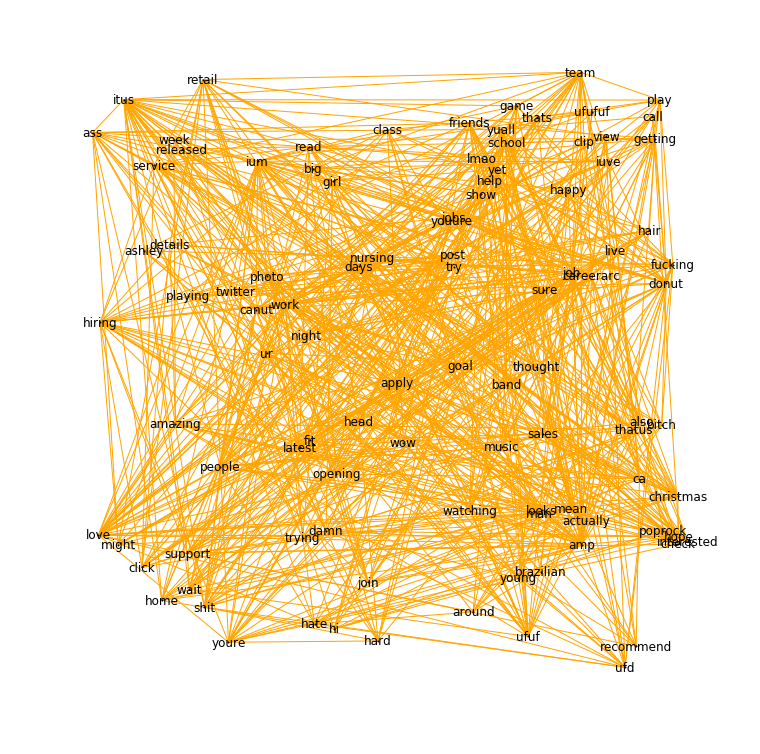

In [22]:
%matplotlib inline

plt.figure(figsize=(10,10))
nx.draw_random(G, node_size=1, edge_size=.5, node_color='black', edge_color='orange', with_labels=True)
plt.savefig("graph.pdf")